Follows from [single_exposure_modeling_test](single_exposure_modeling_test.ipynb) with [spectral_resampling_experiments](spectral_resampling_experiments.ipynb)  to try to speed up the interpolation step.

Most of the tests of the reliability are in those notebooks.

In [1]:
import os
from pathlib import Path

import numpy as np
import cupy as cp


from tqdm.notebook import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy import convolution
from astropy import visualization
from astropy import constants
from astropy.stats import sigma_clip
from astropy.io import fits

import specutils
from specutils import manipulation as specman
from specutils import analysis as specan

from spectres import spectres

from jwst import datamodels

import webbpsf

from IPython import display

def play_text_sound(txt):
    os.system(f'espeak -w /tmp/temp.wav "{txt}"')
    return display.Audio(filename='/tmp/temp.wav', autoplay=True)

In [2]:
%matplotlib inline

visualization.quantity_support()
from matplotlib import pyplot as plt

In [3]:
data_dir = Path('widened_2')

test_path = list(data_dir.glob('*04101_00001_nrs2_cal.fits'))
assert len(test_path) == 1
test_path = test_path[0]

test_dm = datamodels.open(test_path)

example_slit = test_dm.slits[50]

In [4]:
wls = np.quantile(example_slit.wavelength[np.isfinite(example_slit.wavelength)], [0, .5,1])*u.micron

xdat, ydat = np.mgrid[:example_slit.data.shape[0], :example_slit.data.shape[1]]

## Create the PSF and check its size

In [5]:
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

%time psf = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value, oversample=10, fov_arcsec=1)

CPU times: user 17.6 s, sys: 9.81 s, total: 27.4 s
Wall time: 25.4 s


In [6]:
def psf_pix_grid(hdu, scale='arcsec'):
    im = hdu.data
    x = np.arange(im.shape[0])-(psf['OVERDIST'].data.shape[0]-1)/2
    y = np.arange(im.shape[1])-(psf['OVERDIST'].data.shape[1]-1)/2
    if scale == 'arcsec':
        scale = hdu.header['PIXELSCL']*u.arcsec
    elif scale == 'pixel':
        scale = 1
    return np.meshgrid(x*scale, y*scale)

Radius where the flux is within the quantiles [0.5, 0.9, 0.95, 0.99, 0.995, 0.999] :
[0.03040841 0.10031253 0.13131034 0.21539907 0.2442714  0.37948095] arcsec
[ 2.91547595  9.61769203 12.58967831 20.65187643 23.42007686 36.38360033] pix oversampled
[0.29154759 0.9617692  1.25896783 2.06518764 2.34200769 3.63836003] pix detector sampled


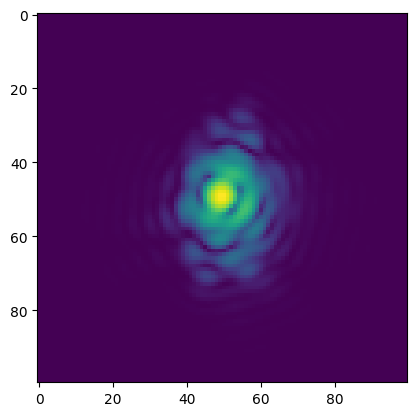

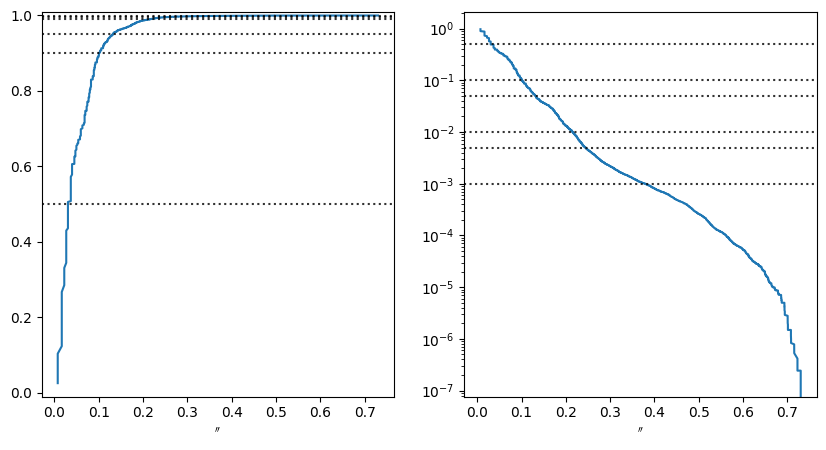

In [7]:
hdu = psf['OVERDIST']

visualization.imshow_norm(hdu.data,
                          interval=visualization.MinMaxInterval(),
                          stretch=visualization.LogStretch())


qs = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pxg, pyg = psf_pix_grid(hdu)
r = np.hypot(pxg, pyg)
sorti = np.argsort(r.ravel())
x = r.ravel()[sorti]
y = np.cumsum(hdu.data.ravel()[sorti])
y = y/y[-1]

ax1.plot(x, y)
ax1.set_ylim(-0.01, 1.01)
for q in qs:
    ax1.axhline(q, c='k', ls=':', alpha=.8)
    
ax2.semilogy(x, 1-y)
for q in qs:
    ax2.axhline(1-q, c='k', ls=':', alpha=.8)

print('Radius where the flux is within the quantiles', qs, ':')
print(np.interp(qs, y, x))
print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)), 'oversampled')
print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP']), 'detector sampled')

This implies a 4x oversampled PSF out to ~3 detector pixels radius should be sufficient, as that means the innermost pixels contains ~50% of the light, and the outmost pixels reach to ~99.7% or so

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     113   (24, 24)   float64   
  1  DET_SAMP      1 ImageHDU       115   (6, 6)   float64   
  2  OVERDIST      1 ImageHDU       158   (24, 24)   float64   
  3  DET_DIST      1 ImageHDU       159   (6, 6)   float64   


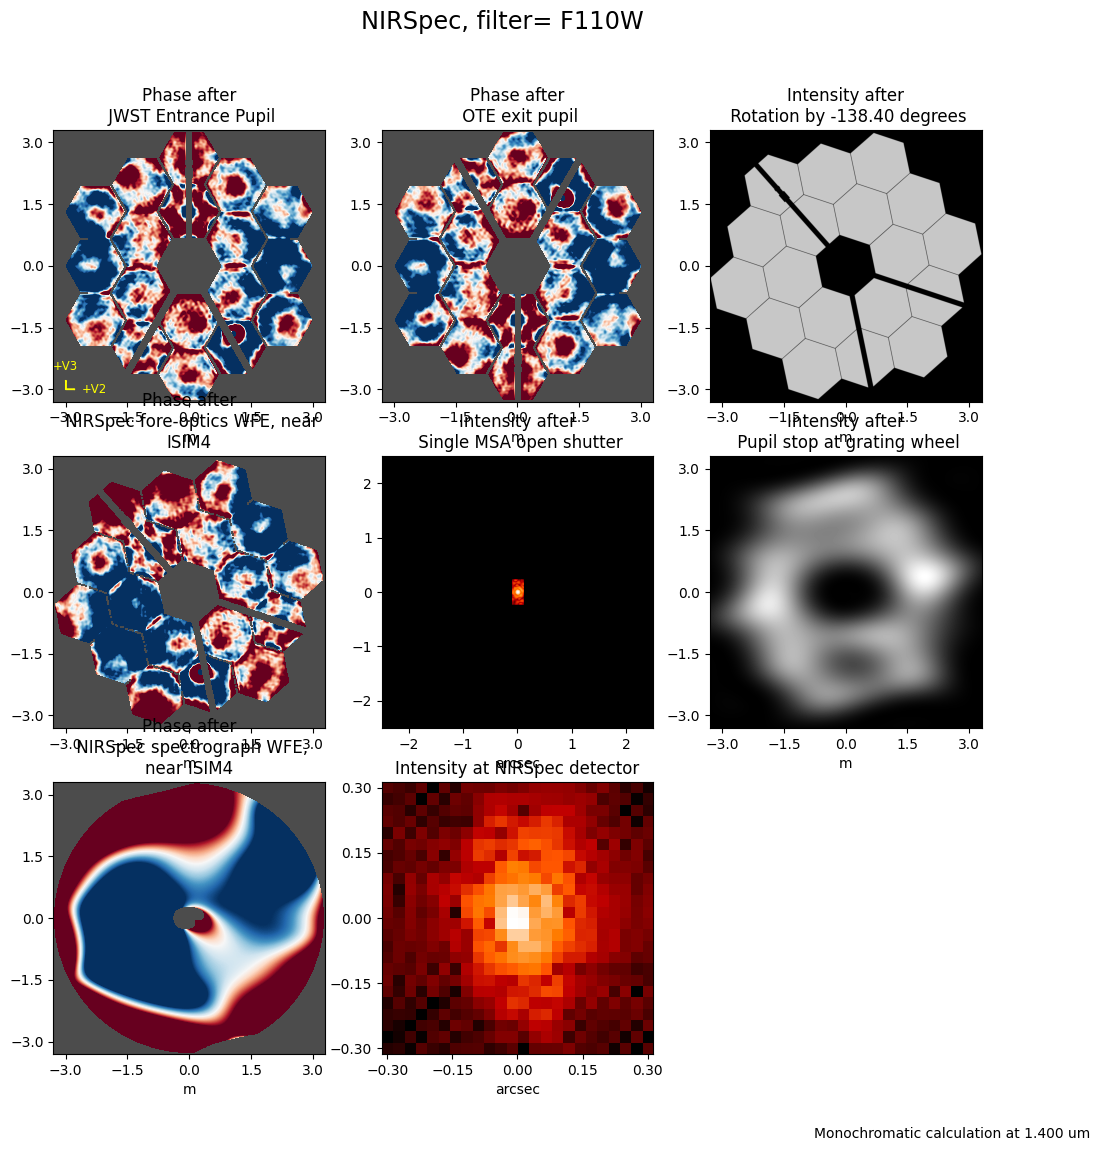

In [8]:
fig = plt.figure(figsize=(12, 12))
psf = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value, oversample=4, fov_pixels=2*3, display=True)
psf.info()

# Load the model spectrum and degrade

Our goal is to degrade to something that's still a bit finer than the LSF (i.e., the "x" part of the PSF)

2023-04-07 21:28:58,329 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


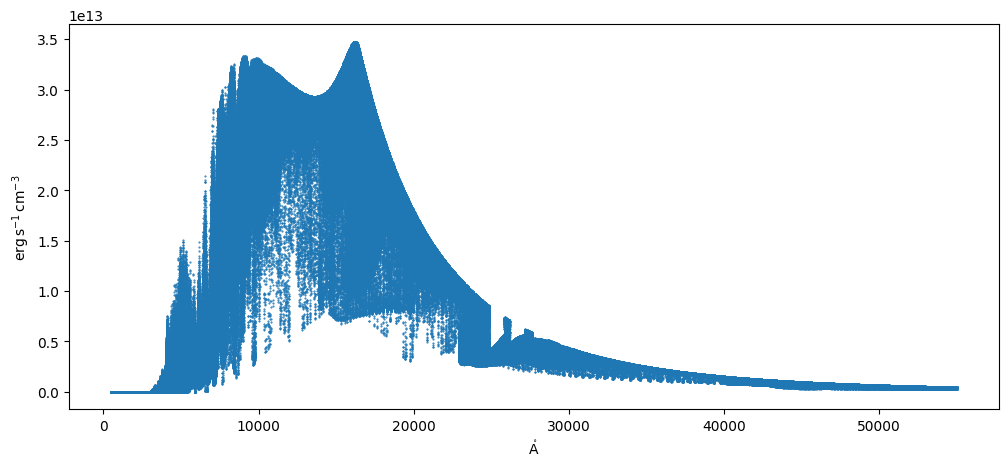

In [9]:
phoenix_model = fits.open('lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_wave = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_spec = specutils.Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

plt.figure(figsize=(12, 5))
plt.plot(phoenix_spec.spectral_axis, phoenix_spec.flux, '.', ms=1);


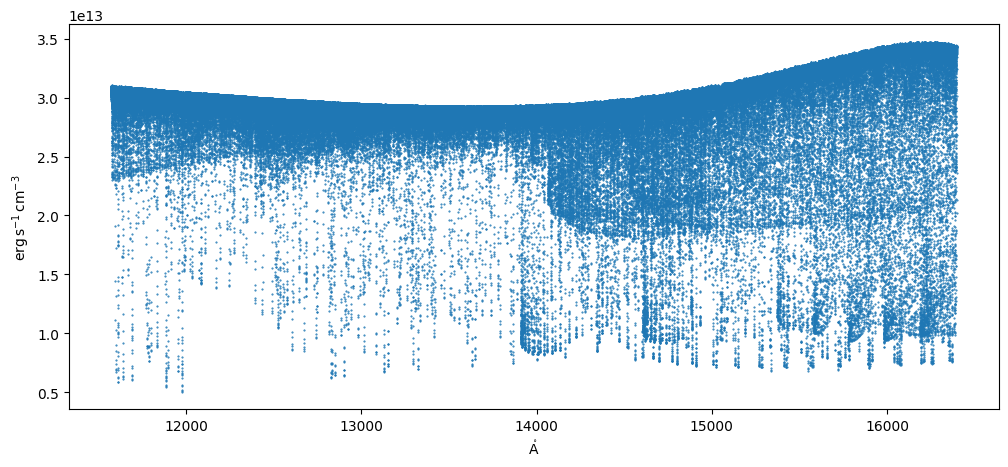

In [10]:
msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = specutils.Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

plt.figure(figsize=(12, 5))
plt.plot(phoenix_sub_spec.spectral_axis, phoenix_sub_spec.flux, '.', ms=1);

Now compare the model spectral resolution to the spectrum

<Quantity 74.5914651>

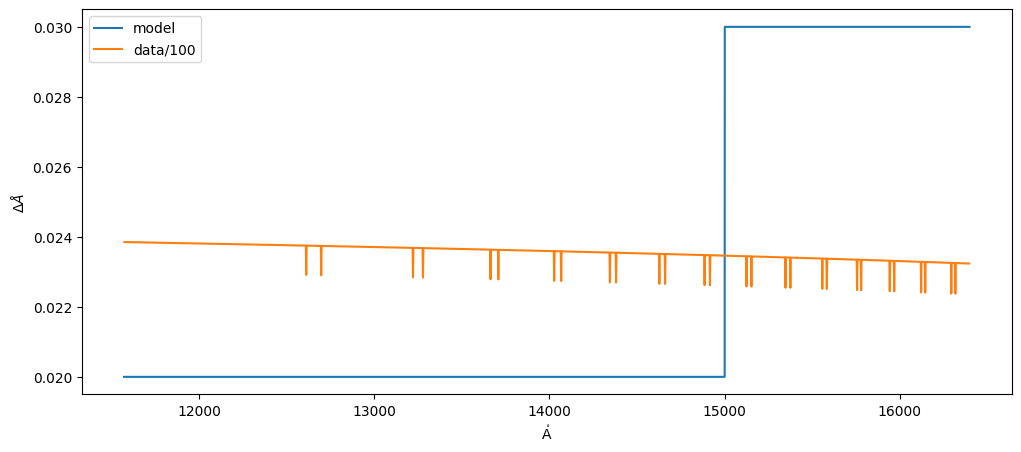

In [11]:
tmp = xdat.astype(float)
tmp[np.isnan(example_slit.data)] = np.nan
centervalid = np.nanmean(tmp, axis=0)
_, spec_px = example_slit.meta.wcs.pixel_to_world(np.arange(centervalid.size)+.5,centervalid)

dmodel = np.diff(phoenix_sub_spec.spectral_axis)

plt.figure(figsize=(12, 5))
plt.plot(phoenix_sub_spec.spectral_axis[:-1], dmodel, label='model')
plt.ylabel('$\Delta \AA$')

plt.plot(spec_px[:-1], np.diff(spec_px)/100, label='data/100')

plt.legend(loc=0)
(np.min(np.diff(spec_px)/np.max(dmodel))).decompose()

Even in the lower-quality  tail, the model spectrum is 75x higher resolution than the data.  So if we decimate by 10 we still get sub-grid sampling of ~7x which is twice the 50% flux radius of the PSF/LSF.

In [12]:
phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit
phoenix_lowres_wl_cens = (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2
len(phoenix_lowres_wl_cens)/example_slit.data.shape[1]

7.85400390625

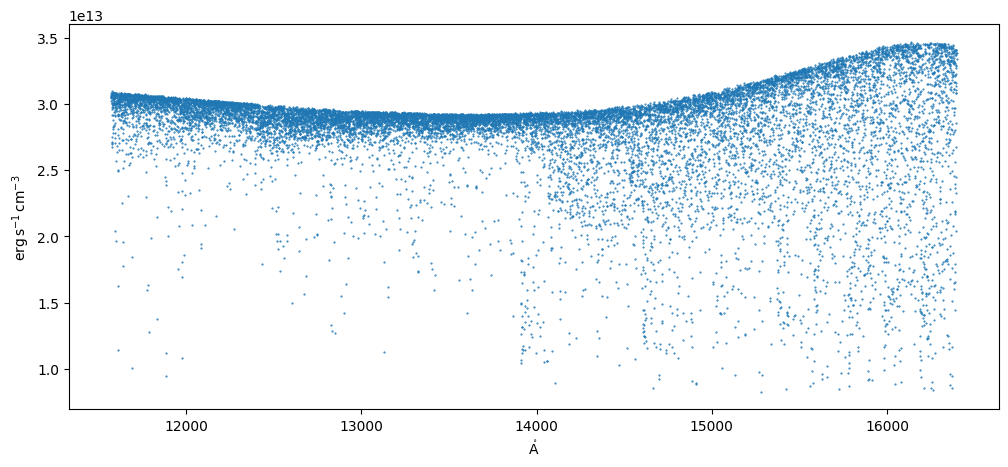

In [13]:
phoenix_lowres_flux = spectres(phoenix_lowres_wl_cens.to(wls.unit).value, 
                               phoenix_sub_spec.spectral_axis.to(wls.unit).value, 
                               phoenix_sub_spec.flux.value)*phoenix_sub_spec.flux.unit
phoenix_lowres = specutils.Spectrum1D(spectral_axis=phoenix_lowres_wl_cens,
                                      flux=phoenix_lowres_flux)

plt.figure(figsize=(12, 5))
plt.plot(phoenix_lowres.spectral_axis, phoenix_lowres.flux,'.', ms=1)

# Set up the example image and the image simulation kernels in the GPU

(1730.0, 1750.0)

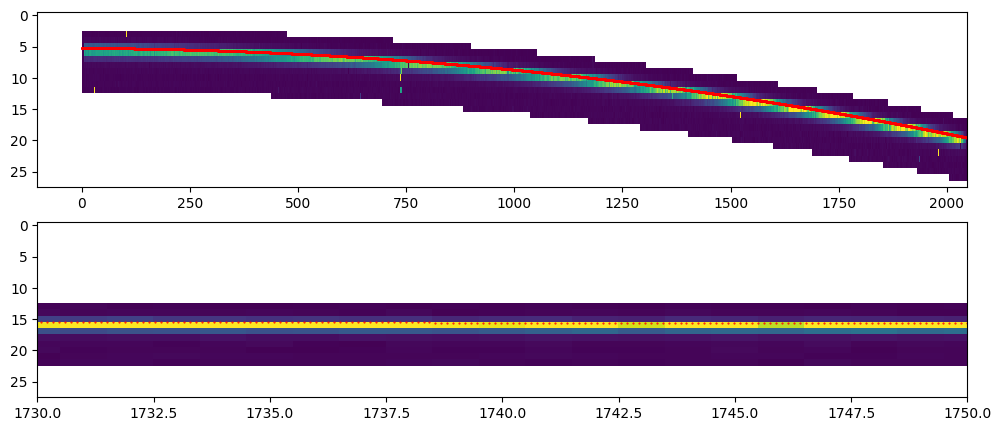

In [14]:
source_coo = SkyCoord(example_slit.source_ra, example_slit.source_dec, unit=u.deg)
xpho, ypho = example_slit.meta.wcs.world_to_pixel(source_coo, phoenix_lowres.spectral_axis)

fig, axs = plt.subplots(2, 1, figsize=(12,5))
for ax in axs:
    visualization.imshow_norm(example_slit.data, aspect='auto',
                              interval=visualization.PercentileInterval(99),
                              stretch=visualization.LinearStretch(),
                              interpolation='nearest', ax=ax)

    ax.plot(xpho, ypho, '.', ms=1, c='r')
axs[1].set_xlim(1730, 1750)

In [15]:
%timeit example_slit.meta.wcs.world_to_pixel(source_coo, phoenix_lowres.spectral_axis)

37.7 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


May need to parallelize the WCS part to get to the desired speed, but maybe not.  For now proceed with a test run.

In [16]:
import cupy as cp

"""
Kernel design:
Blocks = (nim, yim, xim/tpb)
Threads = fast axis of image
"""

convolve_fluxline_src = r"""
extern "C" __global__
void convolve_fluxline(float* fluxim, 
                       const float* fluxpoints, const float* xcens, const float* ycens,
                       const float* psf, const float* pxls, const float* pxus, const float* pyls, const float* pyus,
                       const float psfmaxdistsq, const int nspec, const int psfsize, const float psfpxsz) {
    float fluxaccum = 0;

    float gycen = blockIdx.y;
    float gyl = blockIdx.y - 0.5f;
    float gyu = blockIdx.y + 0.5f;
    
    float gxcen = blockIdx.z * blockDim.x + threadIdx.x;
    float gxl = gxcen - 0.5f;
    float gxu = gxcen + 0.5f;

    for (int i = 0; i < nspec; i++) {
        float xc = xcens[i];
        float yc = ycens[i];

        float dx = xc - gxcen;
        float dy = yc - gycen;
        if ((dx*dx + dy*dy) < psfmaxdistsq) {
            for (int j=0; j < psfsize; j++) {
                // pxls need to be in *image* pixels, not psf pixels
                float pxl = pxls[j] + xc;
                float pxu = pxl + psfpxsz;
                float pyl = pyls[j] + yc;
                float pyu = pyl + psfpxsz;
                dx = fminf(pxu, gxu) - fmaxf(pxl, gxl);
                if (dx > 0) {
                    dy = fminf(pyu, gyu) - fmaxf(pyl, gyl);
                    if (dy > 0) {
                        fluxaccum += fluxpoints[i]*psf[j]*dx*dy;
                    }
                }
            }
        }
    }

    int subdim = blockDim.x*gridDim.z;
    int fluxidx = threadIdx.x + blockIdx.z*blockDim.x + blockIdx.y*subdim + blockIdx.x*subdim*gridDim.y;
    fluxim[fluxidx] = fluxaccum;

}
"""[1:-1]
convolve_fluxline = cp.RawKernel(convolve_fluxline_src, 'convolve_fluxline')

def do_convolve_fluxline(imdata, wcs, simdata, modelspec, psfhdu, raoff=None, decoff=None, v=0*u.km/u.s, tpb=1024):
    if simdata is None: 
        simdata = np.empty_like(imdata)
        
    c_imdata = cp.array(imdata, copy=False, dtype=cp.float32, ndmin=3)
    c_simdata = cp.array(simdata, copy=False, dtype=cp.float32, ndmin=3)
    
    ra = example_slit.source_ra << u.deg
    if raoff is not None:
        ra = ra + raoff
    dec = example_slit.source_dec << u.deg
    if decoff is not None:
        dec = dec + decoff
    
    zp1 = v/constants.c + 1
    x_model, y_model = wcs.world_to_pixel(SkyCoord(ra, dec), modelspec.spectral_axis * zp1)
    c_x_model = cp.asarray(x_model, dtype=cp.float32)
    c_y_model = cp.asarray(y_model, dtype=cp.float32)
    c_modelspec_flux = cp.asarray(modelspec.flux.value, dtype=cp.float32)
    
    
    c_psf = cp.asarray(psfhdu.data, dtype=cp.float32)
    psf_oversampling = psfhdu.header['DET_SAMP']
    xg, yg = np.mgrid[-psfhdu.shape[0]/2:psfhdu.shape[0]/2:psfhdu.shape[0]*1j,
                      -psfhdu.shape[1]/2:psfhdu.shape[1]/2:psfhdu.shape[1]*1j]
    c_pxls = cp.asarray((xg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pxus = cp.asarray((xg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyls = cp.asarray((yg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyus = cp.asarray((yg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_psfmaxdistsq = cp.float32((np.max([xg, yg])/psf_oversampling/2)**2)

    c_nspec = cp.int64(c_modelspec_flux.size)
    c_psfsize = cp.int64(c_psf.size)
    c_psfpxsize = cp.float32(0.5/psf_oversampling)
    
    convolve_fluxline((c_simdata.shape[0], c_simdata.shape[1], c_simdata.shape[2]/tpb), (tpb,), 
                      (c_simdata, c_modelspec_flux, c_x_model, c_y_model,
                       c_psf, c_pxls, c_pxus, c_pyls, c_pyus, c_psfmaxdistsq,
                       c_nspec, c_psfsize, c_psfpxsize))
    
    return c_simdata


In [17]:
%%timeit

arr = do_convolve_fluxline(example_slit.data, example_slit.meta.wcs, None, phoenix_lowres, psf['OVERDIST']).get()

55.1 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


(<matplotlib.image.AxesImage at 0x7f8f98c02cd0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f8fa363e5d0>)

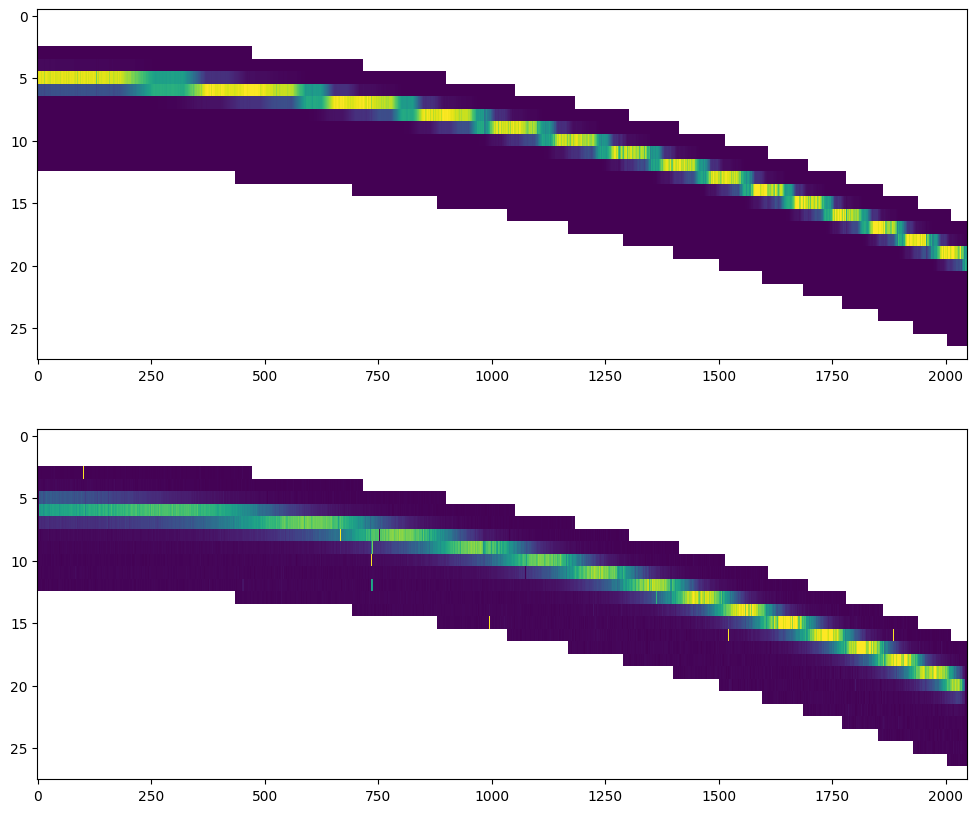

In [18]:
res = do_convolve_fluxline(example_slit.data, example_slit.meta.wcs, None, phoenix_lowres, psf['OVERDIST'])
arr = res.get()[0]

arr[np.isnan(example_slit.data)] = np.nan

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
visualization.imshow_norm(arr, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=ax1)
visualization.imshow_norm(example_slit.data, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=ax2)

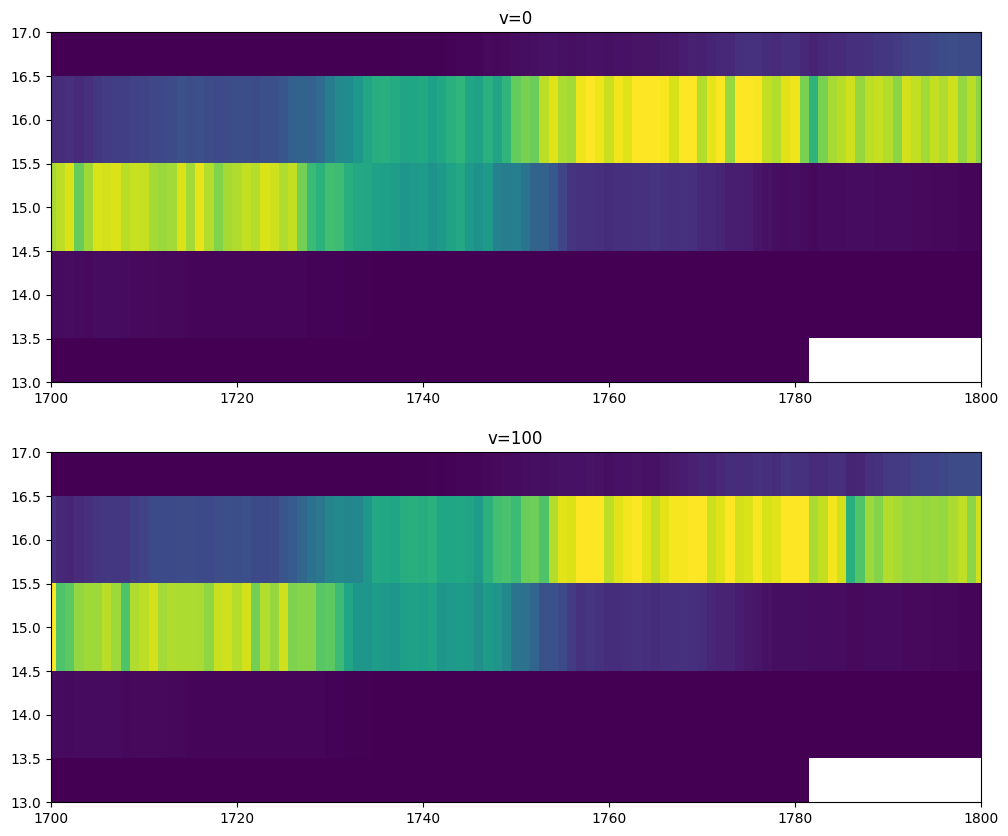

In [19]:
res = do_convolve_fluxline(example_slit.data, example_slit.meta.wcs, None, phoenix_lowres, psf['OVERDIST'], v=200*u.km/u.s)
arr = res.get()[0]
res = do_convolve_fluxline(example_slit.data, example_slit.meta.wcs, None, phoenix_lowres, psf['OVERDIST'], v=0*u.km/u.s)
arr0 = res.get()[0]

arr[np.isnan(example_slit.data)] = np.nan
arr0[np.isnan(example_slit.data)] = np.nan

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
visualization.imshow_norm(arr0, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=ax1)
ax1.set_title('v=0')
visualization.imshow_norm(arr, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=ax2)
ax2.set_title('v=100')

for ax in ax1, ax2:
    ax.set_xlim(1700, 1800)
    ax.set_ylim(13, 17)

# Fit simulated data

Now try doing MCMC on this for the 3 key parameters

In [20]:
import emcee
import corner

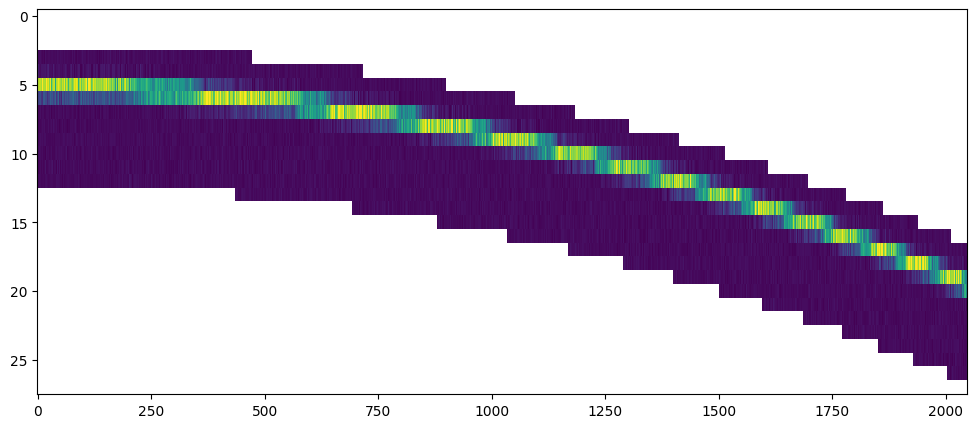

In [22]:
simulated_data_noiseless = do_convolve_fluxline(example_slit.data, example_slit.meta.wcs, None, phoenix_lowres, psf['OVERDIST'], v=200*u.km/u.s).get()[0]
mx = np.max(simulated_data_noiseless)
simulated_data_std = (simulated_data_noiseless/mx/100)**0.5 * mx + mx/100
simulated_data = simulated_data_noiseless + np.random.randn(*simulated_data_std.shape)*simulated_data_std

simulated_data[np.isnan(example_slit.data)] = np.nan

plt.figure(figsize=(12, 5))
visualization.imshow_norm(simulated_data, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest');

In [23]:
GAUSS_LPRETERM = -0.5*np.log(2*np.pi)
def loglikes(ps, data, std, wcs):
    vkms, raoff, decoff, A = ps
    sim_data = do_convolve_fluxline(data, wcs, None, phoenix_lowres, psf['OVERDIST'], 
                                    v=vkms*u.km/u.s, raoff=raoff*u.arcsec, decoff=decoff*u.arcsec).get()[0]
    
    x = (sim_data*A-data)/std
    return -0.5*x**2 - np.log(std) + GAUSS_LPRETERM
    return np.nansum(loglikes)

def logpri(ps):
    # starndard uniform priors
    vkms, raoff, decoff, A = ps
    if np.hypot(raoff, decoff) > 0.3:
        return np.NINF
    if vkms < -1000 or vkms > 1000:
        return np.NINF
    if A < 0.1 or A > 3:
        return np.NINF
    
    return 0

def logprob(ps, data, std, wcs):
    logprival = logpri(ps)
    if logprival == np.NINF:
        return np.NINF
    return np.nansum(loglikes(ps, data, std, wcs)) + logprival 

In [26]:
sampler = emcee.EnsembleSampler(12, 4, logprob, args=(simulated_data, simulated_data_std, example_slit.meta.wcs))
p0s = np.random.rand(12, 4) - .5
# intentionally only filling half the prior
p0s[:, 1:3] *= .3
p0s[:, 0] *= 1000  
p0s[:, 3] += 1

In [27]:
res = sampler.run_mcmc(p0s, 1000, progress='notebook')

/usr/local/lib/python3.11/site-packages/cupy/_creation/from_data.py:46: RuntimeWarning: overflow encountered in cast
  return _core.array(obj, dtype, copy, order, subok, ndmin)


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/cupy/_creation/from_data.py:46: RuntimeWarning: invalid value encountered in cast
  return _core.array(obj, dtype, copy, order, subok, ndmin)


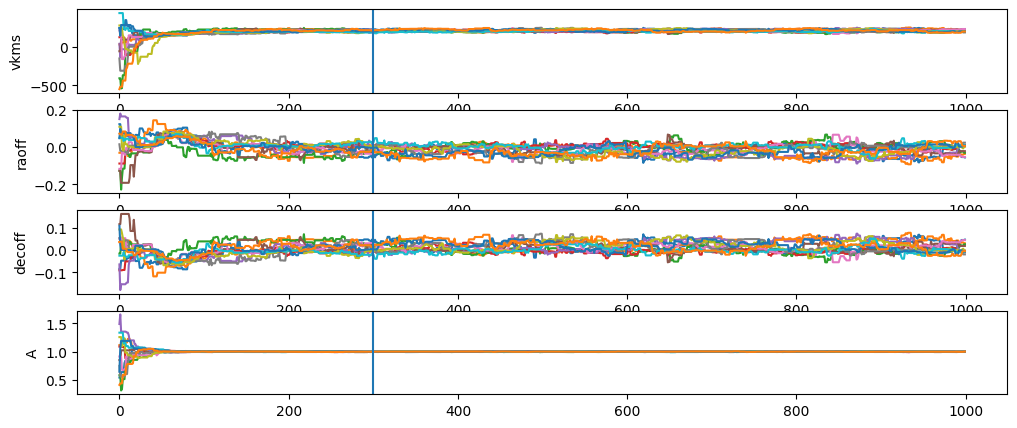

<Figure size 800x800 with 0 Axes>

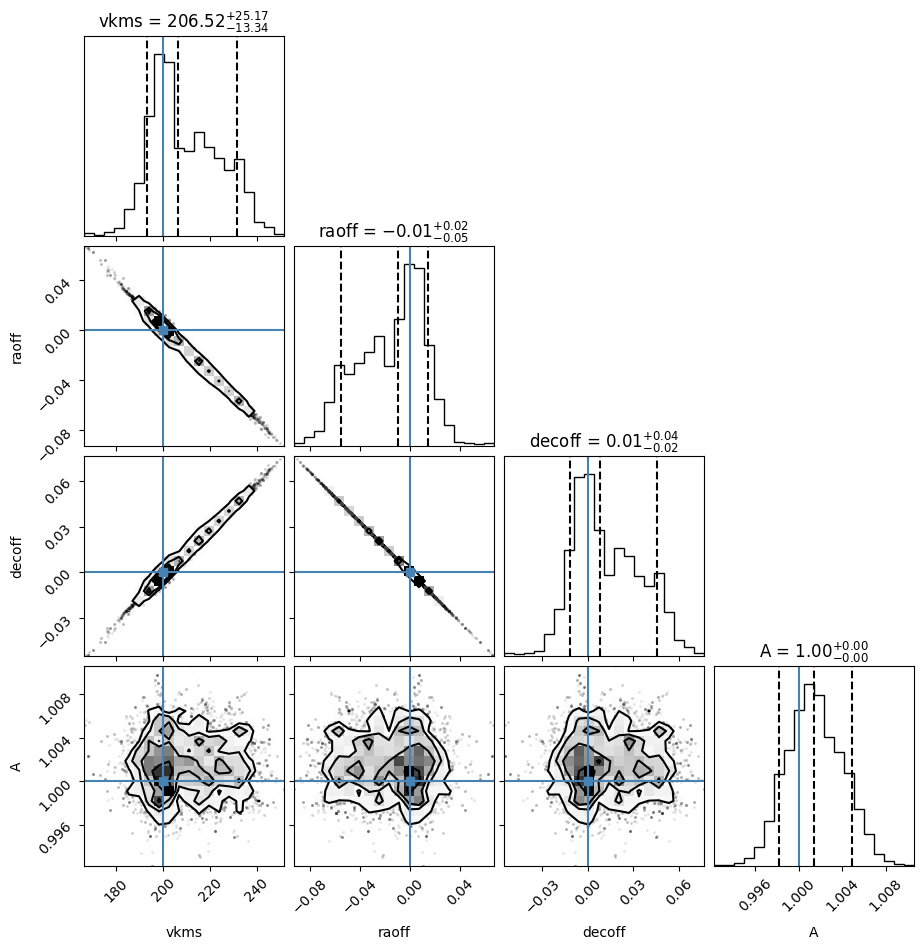

In [28]:
labels = 'vkms, raoff, decoff, A'.split(', ')
truths = [200, 0, 0, 1]
ndiscard = 300



fig, axs = plt.subplots(len(labels), 1, figsize=(12, 5))
for i, (l, ax) in enumerate(zip(labels, axs)):
    ax.plot(sampler.chain.T[i])
    ax.set_ylabel(l)
    ax.axvline(ndiscard)

plt.figure(figsize=(8, 8))
corner.corner(sampler.get_chain(discard=ndiscard, flat=True), labels=labels, truths=truths, show_titles=True, quantiles=[.1,.5,.9]);

100.0 marcsec 206.19191341870447 24.834631643415634 -13.06186387890807
50.0 marcsec 202.30463249221978 15.704841856711454 -9.831409802518493
10.0 marcsec 200.79021096755127 3.323985885050547 -3.244697951241136
5.0 marcsec 201.01707825645656 1.599612142495829 -1.8637491297135682
3.0 marcsec 201.00550834564032 1.1519672609605607 -1.1792649027114237
1.0 marcsec 200.9100653138562 0.6604436514305121 -0.4432096192881829


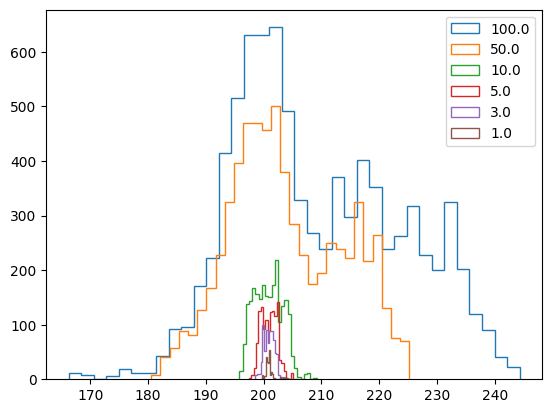

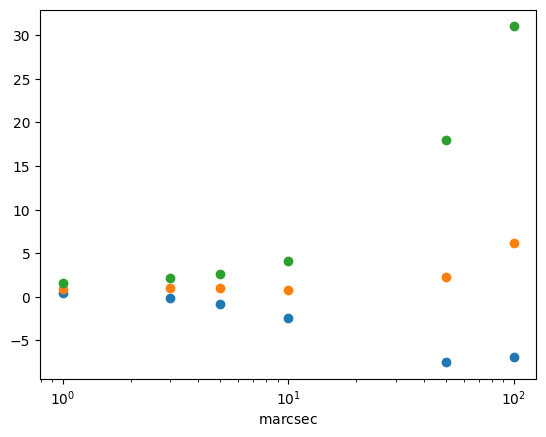

In [180]:
v,rao, deco, A = sampler.get_chain(discard=ndiscard, flat=True).T
off = np.hypot(rao, deco)*1000*u.marcsec
np.sum(off < 5*u.marcsec)/len(off)

qss =[]
lims = [100,50, 10, 5, 3, 1]*u.marcsec
for lim in lims:
    vclose = v[off < lim]
    plt.hist(vclose, bins='auto', histtype='step', label=lim)
    qs = np.quantile(vclose, [.1, .5, .9])
    qss.append(qs)
    print(lim, qs[1], qs[2]-qs[1], qs[0]-qs[1])
plt.legend(loc=0);

plt.figure()
plt.semilogx(lims, np.array(qss)-200, 'o')

So... Constraining the astrometry to ~10 marcsec -> 3 km/s, and ~3 marcsec for 1 km/s